In [2]:
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import scipy as sp
import os, sys,glob, copy
import pandas as pd

import matplotlib.pyplot as plt
plt.style.use('default')
%matplotlib inline

sys.path.append("/Users/xiaoxuanj/work/work_allen/Ephys/code_library/ephys_code")

import data_loader as dl

import matrix_utils as mu

import functional_clustering as fc


In [3]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.neighbors import NearestNeighbors

from scipy.spatial.distance import cdist
from scipy.stats import chi2
from scipy.ndimage.filters import gaussian_filter1d


def lda_metrics(all_pcs, all_labels, this_unit_id):

    """ Calculates d-prime based on Linear Discriminant Analysis
    Based on metric described in Hill et al. (2011) J Neurosci 31: 8699-8705
    Inputs:
    -------
    all_pcs : numpy.ndarray (num_units x PCs)
        2D array of PCs for all spikes
    all_labels : numpy.ndarray (num_units x 0)
        1D array of cluster labels for all spikes
    this_unit_id : Int
        number corresponding to cluster for which these metrics will be calculated
    Outputs:
    --------
    d_prime : float
        Isolation distance of this unit
    l_ratio : float
        L-ratio for this unit
    """
    
    X = all_pcs
    
    y = np.zeros((X.shape[0],),dtype='bool')
    y[all_labels == this_unit_id] = True
    
    lda = LDA(n_components=1)
    
    X_flda = lda.fit_transform(X, y)
      
    flda_this_cluster  = X_flda[np.where(y)[0]]
    flda_other_cluster = X_flda[np.where(np.invert(y))[0]]
        
    d_prime = (np.mean(flda_this_cluster) - np.mean(flda_other_cluster))/np.sqrt(0.5*(np.std(flda_this_cluster)**2+np.std(flda_other_cluster)**2))
        
    return d_prime



def nearest_neighbors_metrics(all_pcs, all_labels, this_unit_id, max_spikes_for_nn, n_neighbors):

    """ Calculates cluster contamination based on NearestNeighbors search in PCA space
    Based on metrics described in Chung, Magland et al. (2017) Neuron 95: 1381-1394:
    "
    we describe the isolation metric for assessing how well a cluster is separated from the other clusters. 
    fraction of the nearest neighbors that are classified consistently with their parent point. (Often the 
    number of points in one cluster will be much larger than in the other. This can lead to an artificially 
    high overlap metric because the likelihood of misclassification depends not only on the degree of 
    separation but also on the relative sizes of the clusters. Therefore we only sample N random points from
    each of the two clusters where N is the minimum size of the two clusters. To reduce computation time we 
    also require that N is at most 500.) 
    "
    
    Inputs:
    -------
    all_pcs : numpy.ndarray (num_units x PCs)
        2D array of PCs for all spikes
    all_labels : numpy.ndarray (num_units x 0)
        1D array of cluster labels for all spikes
    this_unit_id : Int
        number corresponding to cluster for which these metrics will be calculated
    max_spikes_for_nn : Int
        number of units to use (calculation can be very slow when this number is >20000)
    n_neighbors : Int
        number of neighbors to use
    Outputs:
    --------
    hit_rate : float
        Fraction of neighbors for target cluster that are also in target cluster
    miss_rate : float
        Fraction of neighbors outside target cluster that are in target cluster
    """

    total_spikes = all_pcs.shape[0]
    ratio = max_spikes_for_nn / float(total_spikes)
    this_unit = all_labels == this_unit_id
    
    X = np.concatenate((all_pcs[this_unit,:], all_pcs[np.invert(this_unit),:]),0)

    n = np.sum(this_unit)
    
    if ratio < 1:
        inds = np.arange(0,X.shape[0]-1,1/ratio).astype('int')
        X = X[inds,:]
        n = int(n * ratio)
        

    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='ball_tree').fit(X)
    distances, indices = nbrs.kneighbors(X)   
    
    this_cluster_inds = np.arange(n)
    
    this_cluster_nearest = indices[:n,1:].flatten()
    other_cluster_nearest = indices[n:,1:].flatten()
    
    hit_rate = np.mean(this_cluster_nearest < n)
    miss_rate = np.mean(other_cluster_nearest < n)
    
    return hit_rate, miss_rate



# compute dprime and hit-rate for each cluster

In [ ]:
mouse_IDs = ['306046','388523', '389262','408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116'] #  
n_boot=3

for mouse_ID in mouse_IDs:
    X = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/adjacency_matrix/RF_onscreen/mouse'+mouse_ID+'_adjacency_matrix_RF.npy')

    dprime_k=[]
    hr_k=[]
    for k in np.arange(2,9):
        kernel=k
        D_b=[]
        HR_b=[]
        for b in range(n_boot):
            FC = fc.functional_clustering(np.nan_to_num(X))
            # normalize and PCA
            FC.normalize()
            FC.pca()
            # plotted cov of connectivity matrix

            # probiliaty matrix from kmeans
            matrix = FC.probability_matrix(k, data=FC.Z.T)

            # hierarchical clustering
            FC.linkage()

            # plot hierarchical clustering matrix
            FC.plot_matrix()

            # save output cluster ids
            FC.predict_cluster(k=kernel)
            labels= FC.clusters-1

            all_pcs = FC.Z.T

            plt.figure(figsize=(4,4))
            for i in np.unique(labels):
                plt.scatter(FC.Z.T[labels==i,0], FC.Z.T[labels==i,1])


            # subsample to avoid bias introduced by number of samples
            max_spikes_for_nn=min([len(labels[labels==i]) for i in np.unique(labels)])
            if max_spikes_for_nn>500:
                max_spikes_for_nn=500

            # determined by maximize sum(hr)
            n_neighbors=3 

            d=[]
            iso_dist=[]
            hr=[]
            for this_unit_id in np.unique(labels):

                d_prime = lda_metrics(all_pcs, labels, this_unit_id)

                hit_rate, miss_rate = nearest_neighbors_metrics(all_pcs, labels, this_unit_id, 
                                                                max_spikes_for_nn, n_neighbors)

                d.append(d_prime)
                hr.append(hit_rate)

            D=np.nanmean(d)
            HR=np.nanmean(hr)
            #print('dprime', D, 'hit-rate', HR)

            D_b.append(D)
            HR_b.append(HR)
        d_final=np.nanmean(D_b)
        hr_final=np.nanmean(HR_b)
        print('dprime', d_final, 'hit-rate', hr_final)
        dprime_k.append(d_final)
        hr_k.append(hr_final)

    plt.figure(figsize=(8,3))
    plt.subplot(121)
    plt.plot(dprime_k)
    plt.subplot(122)
    plt.plot(hr_k)

    np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/cluster_quality/mouse'+mouse_ID+'qc.npy',[np.array(dprime_k),np.array(hr_k)])


In [19]:
np.save('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/cluster_quality/mouse'+mouse_ID+'qc.npy',)


In [28]:
mouse_IDs = ['306046','388523', '389262','408153','410344', '415149', '412809', '412804',
             '416856', '419114',  '419117', '419118', '419119', '424445',
             '415148', '416356', '416861','419112','419116'] #  
d_all=[]
k_all=[]
for mouse_ID in mouse_IDs:
    d,k = np.load('/Users/xiaoxuanj/work/work_allen/Ephys/processed_data/cluster_quality/mouse'+mouse_ID+'qc.npy')
    d_all.append(d)
    k_all.append(k)
d_all=np.array(d_all)
k_all=np.array(k_all)

In [30]:
np.nanmean(d, axis=0)

3.53954636725862

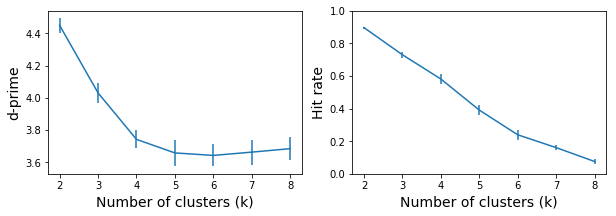

In [37]:
plt.figure(figsize=(10,3))
plt.subplot(121)
plt.errorbar(np.arange(2,9), np.nanmean(d_all, axis=0), np.nanstd(d_all, axis=0)/np.sqrt(d_all.shape[0]))
plt.ylabel('d-prime', fontsize=14)
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.subplot(122)
plt.errorbar(np.arange(2,9), np.nanmean(k_all, axis=0), np.nanstd(k_all, axis=0)/np.sqrt(k_all.shape[0]))
plt.ylim(0,1)
plt.ylabel('Hit rate', fontsize=14)
plt.xlabel('Number of clusters (k)', fontsize=14)
plt.savefig('/Users/xiaoxuanj/Documents/Paper_functional_connectivity/materials/cluster_quality.pdf')
